### В выгрузке неагренированные данные по пользователям, которые зарегистрировались на платформе в сентябре, по двум игровым платформам (rra_brandId).

**Необходимо:**  
- изучить датасет 
- выбрать 4 когорты пользователей, в соотсветствии с 4 неделями сентября и сопоставить их  
- вытащить любые инсайты из данных (распределение по полу, возрасту, странам)  
- рассчитать основные метрики (ARPU, удержание, LTV и т.п.)  

In [72]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn
%matplotlib inline

In [73]:
data_store = pd.HDFStore('export_data.h5')
df = data_store['export_df']
data_store.close()
df_reten = df.copy()
dfa = df.copy()


### 1. Изучить датасет

In [74]:
df.head()

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age
58,100508071713418294,5504921,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:08:36,m,54.0
59,236239403559361495,5504921,2020-10-02 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:08:36,m,54.0
60,100508071713418299,5504961,2020-09-17 03:00:00,85405,99,100847,AU,1,1,30.88,30.88,2020-09-17 11:53:13,f,55.0
61,157339966022599381,5504961,2020-10-08 03:00:00,85405,99,100847,AU,0,1,0.00,30.48,2020-09-17 11:53:13,f,55.0
62,158783148201370844,5504961,2020-11-12 03:00:00,85405,99,100847,AU,0,0,0.00,0.00,2020-09-17 11:53:13,f,55.0


В датасете следующие поля:  
'rra_id' - id записи  
'rra_playerId' - id игрока  
'rra_dateAt' - дата записи  
'rra_partnerId' - id партнера, который привел игрока  
'rra_brandId' - id игровой платформы  
'rra_campaignId' - id маркетинговой кампании  
'rra_playerCountry' - страна игрока  
'rra_registrationsCount' - флаг регистрации игрока в дату rra_dateAt  
'rra_depositsCount' - кол-во взносов игрока на игровой счет  
'firstDepositsSumEur' - сумма первого взноса игрока на игровой счет  
'depositsSumEur' - сумма взносов игрока на игровой счет на дату rra_dateAt  
'c_registrationDateAt' - дата регистрации  
'c_gender' - пол игрока  
'c_age' - возраст игрока  

In [75]:
# Пример вывода по данным

df[df['rra_playerId'] == '5505085'][['rra_playerId', 'rra_dateAt', 
                                     'rra_depositsCount', 'firstDepositsSumEur',
                                     'depositsSumEur', 'c_registrationDateAt']] # Пример записей одного пользователя

,rra_playerId,rra_dateAt,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt
78,5505085,2020-09-17 03:00:00,2,25.0,75.0,2020-09-17 11:28:58
79,5505085,2020-11-26 03:00:00,1,0.0,50.0,2020-09-17 11:28:58
80,5505085,2020-11-20 03:00:00,1,0.0,100.0,2020-09-17 11:28:58
81,5505085,2020-09-18 03:00:00,1,0.0,50.0,2020-09-17 11:28:58
82,5505085,2020-09-26 03:00:00,0,0.0,0.0,2020-09-17 11:28:58
83,5505085,2020-11-17 03:00:00,2,0.0,200.0,2020-09-17 11:28:58
84,5505085,2020-11-21 03:00:00,1,0.0,100.0,2020-09-17 11:28:58
85,5505085,2020-11-25 03:00:00,1,0.0,100.0,2020-09-17 11:28:58


- Имеется значение в колонке 'firstDepositsSumEur' > 0 -> Запись первого депозита  
- Значение в колонке firstDepositsSumEur' = 0 и имеется значение в колонке 'rra_depositsCount' -> Записи остальных депозитов кроме первого
- 'rra_depositsCount' = 0 -> Сумма депозитов = 0 -> Отсутсвуют взносы в рассматриваемый день
- В разделе подсчета ARPPU демонстрируется, что пользователям для первого входа необходим депозит

In [76]:
d1 = df.groupby(['rra_playerId', 'c_registrationDateAt']).agg({'rra_dateAt' : 'min'}).reset_index()

d2 = d1[d1['c_registrationDateAt'] < d1['rra_dateAt']]
d3 = d1[d1['c_registrationDateAt'] > d1['rra_dateAt']]

print('Количество пользователей, которые зарегистрировались после некоторого времени использования:', d3.shape[0])
print('Количество пользователей, которые сначала зарегистрировались, а потом начали использование платформы:', d2.shape[0])
print('Всего уникальных пользователей:', df[['rra_playerId']].nunique()[0])

Количество пользователей, которые зарегистрировались после некоторого времени использования: 5231
Количество пользователей, которые сначала зарегистрировались, а потом начали использование платформы: 1411
Всего уникальных пользователей: 6642


In [77]:
df.dtypes # Типы колонок

rra_id                             int64
rra_playerId                      object
rra_dateAt                datetime64[ns]
rra_partnerId                     object
rra_brandId                       object
rra_campaignId                    object
rra_playerCountry                 object
rra_registrationsCount             int64
rra_depositsCount                  int64
firstDepositsSumEur              float64
depositsSumEur                   float64
c_registrationDateAt      datetime64[ns]
c_gender                          object
c_age                            float64
dtype: object

In [78]:
df.info() # Непустые значения в колонках

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28085 entries, 58 to 267383
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   rra_id                  28085 non-null  int64         
 1   rra_playerId            28085 non-null  object        
 2   rra_dateAt              28085 non-null  datetime64[ns]
 3   rra_partnerId           28085 non-null  object        
 4   rra_brandId             28085 non-null  object        
 5   rra_campaignId          28085 non-null  object        
 6   rra_playerCountry       28085 non-null  object        
 7   rra_registrationsCount  28085 non-null  int64         
 8   rra_depositsCount       28085 non-null  int64         
 9   firstDepositsSumEur     28085 non-null  float64       
 10  depositsSumEur          28085 non-null  float64       
 11  c_registrationDateAt    28085 non-null  datetime64[ns]
 12  c_gender                28085 non-null  obje

In [79]:
df[['rra_playerId']].nunique()[0] # Количество уникальных пользователей за все время

6642

In [80]:
df.drop_duplicates(subset='rra_playerId')[['c_age']].describe() # Возраст пользователей

,c_age
count,6642.000000
mean,33.820536
std,10.584357
min,0.000000
25%,26.000000
50%,32.000000
75%,40.000000
max,112.000000


In [81]:
df.drop_duplicates(subset='rra_playerId')[['firstDepositsSumEur']].describe() # Первые депозиты

,firstDepositsSumEur
count,6642.000000
mean,15.997391
std,28.896223
min,0.000000
25%,0.000000
50%,9.245000
75%,20.000000
max,919.050000


In [82]:
df[['depositsSumEur']].describe() # Суммарные депозиты

,depositsSumEur
count,28085.000000
mean,68.369253
std,413.336827
min,0.000000
25%,0.000000
50%,20.000000
75%,50.000000
max,52500.000000


<AxesSubplot:ylabel='None'>

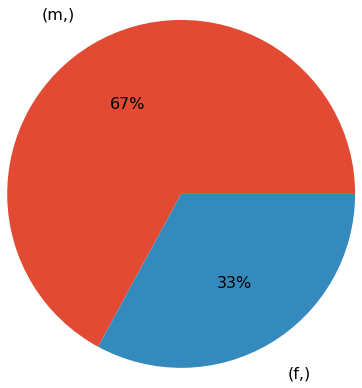

In [83]:
df[['c_gender']].value_counts().plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2) # Распределение по полу

In [84]:
df.drop_duplicates(subset=['rra_playerId']).groupby('rra_brandId')[['rra_playerId']].count()

# Количество уникальных пользователей на каждой платформе

,rra_playerId
rra_brandId,
102,3567
99,3075


In [85]:
df[['c_age']].sort_values(by='c_age') # Исправление ошибок в возрасте

,c_age
191002,0.0
160284,0.0
160285,0.0
206137,0.0
194379,0.0
...,...
211233,106.0
211232,106.0
211243,106.0
211230,106.0


In [86]:
df['c_age'] = [value if (value > 18) and (value < 90) else np.NaN for value in df['c_age']]
df = df.fillna({'c_age' : df['c_age'].median()}) # Заменяем на медианные значения

In [87]:
df[['rra_depositsCount']].sort_values(by='rra_depositsCount', ascending=False)

,rra_depositsCount
158162,46
181381,45
193985,41
190814,30
254153,27
...,...
191582,0
191583,0
155412,0
191589,0


### 2. Выбрать 4 когорты пользователей, в соотсветствии с 4 неделями сентября и сопоставить их

In [88]:
print(df['c_registrationDateAt'].min(),'\n', df['c_registrationDateAt'].max()) # Размах дат регистрации

2020-09-02 00:09:50 
 2020-09-29 23:53:09


In [89]:
print(df['rra_dateAt'].min(),'\n', df['rra_dateAt'].max()) # Размах дат логов действий

2020-09-01 03:00:00 
 2020-12-24 03:00:00


In [90]:
# Разделение на когорты в соответствии с неделями сентября

df.loc[(df['c_registrationDateAt'] >= '2020-09-02') & (df['c_registrationDateAt'] < '2020-09-09'), 'Cohort'] = 'A'
df.loc[(df['c_registrationDateAt'] >= '2020-09-09') & (df['c_registrationDateAt'] < '2020-09-16'), 'Cohort'] = 'B'
df.loc[(df['c_registrationDateAt'] >= '2020-09-16') & (df['c_registrationDateAt'] < '2020-09-23'), 'Cohort'] = 'C'
df.loc[(df['c_registrationDateAt'] >= '2020-09-23') & (df['c_registrationDateAt'] < '2020-09-30'), 'Cohort'] = 'D'

In [91]:
# Количество пользователей в когортах
df__a = df.copy()
df_count = df.drop_duplicates(subset=['rra_playerId'])['Cohort'].value_counts()
df_count

A    2036
B    1605
C    1527
D    1474
Name: Cohort, dtype: int64

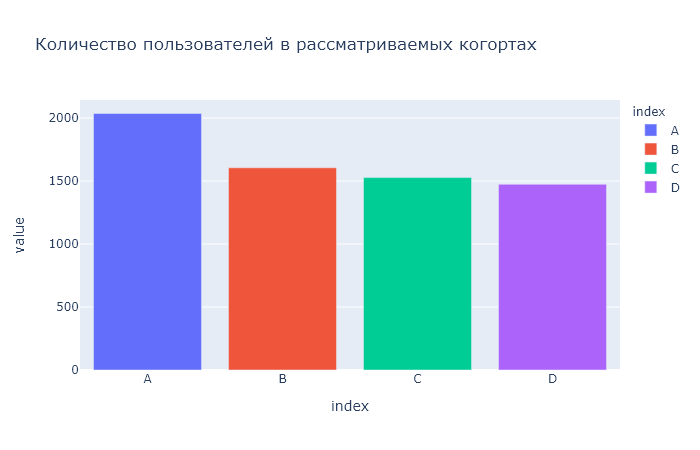

In [92]:
fig = px.bar(df_count,
       color=df_count.index,
        title='Количество пользователей в рассматриваемых когортах', width=800)
fig.show("png")

In [93]:
# Когортный анализ

dates = [['2020-09-02', '2020-09-08'],
         ['2020-09-09', '2020-09-15'],
         ['2020-09-16', '2020-09-22'],
         ['2020-09-23', '2020-09-29']]

for i,value in enumerate(np.unique(df['Cohort'])):
    df_coh = df[df['Cohort'] == value].drop_duplicates(subset='rra_playerId')
    d1 = df_coh.groupby(['rra_playerId', 'c_registrationDateAt']).agg({'rra_dateAt' : 'min'}).reset_index()
    d2 = d1[d1['c_registrationDateAt'] < d1['rra_dateAt']]
    d3 = d1[d1['c_registrationDateAt'] > d1['rra_dateAt']]
    mean_age = df_coh['c_age'].mean()
    genders = df_coh.groupby('c_gender')['rra_playerId'].count().values
    countries = pd.DataFrame(df_coh.groupby('rra_playerCountry')['rra_playerId'].count()) \
                .sort_values(by='rra_playerId', ascending=False).head(10).to_dict()['rra_playerId']
    print('Когорта:', value)
    print('Число пользователей:', df_coh.shape[0])
    print('Количество пользователей, которые зарегистрировались после некоторого времени использования:', d3.shape[0])
    print('Количество пользователей, которые сначала зарегистрировались, а потом начали использование платформы:', d2.shape[0])
    print('Дата регистрации: c {} по {}'.format(dates[i][0], dates[i][1]))
    print('Средний возраст = {}'.format(round(mean_age, 3)))
    print('Женщицы: {}, мужчины: {}'.format(genders[0], genders[1]))
    print('Количество игроков в странах:\n', countries)
    print('=========================================================================================================')

Когорта: A
Число пользователей: 2036
Количество пользователей, которые зарегистрировались после некоторого времени использования: 971
Количество пользователей, которые сначала зарегистрировались, а потом начали использование платформы: 1065
Дата регистрации: c 2020-09-02 по 2020-09-08
Средний возраст = 33.201
Женщицы: 631, мужчины: 1405
Количество игроков в странах:
 {'AU': 803, 'NL': 609, 'NO': 180, 'FI': 120, 'DE': 112, 'CA': 62, 'DK': 39, 'NZ': 26, 'CZ': 13, 'AT': 9}
Когорта: B
Число пользователей: 1605
Количество пользователей, которые зарегистрировались после некоторого времени использования: 615
Количество пользователей, которые сначала зарегистрировались, а потом начали использование платформы: 990
Дата регистрации: c 2020-09-09 по 2020-09-15
Средний возраст = 33.474
Женщицы: 464, мужчины: 1141
Количество игроков в странах:
 {'AU': 528, 'NL': 503, 'NO': 134, 'FI': 133, 'DE': 130, 'CA': 41, 'CZ': 28, 'CH': 20, 'AT': 16, 'NZ': 16}
Когорта: C
Число пользователей: 1527
Количество по

- Больше всего пользователей зарегистрировалось в неделю c 2020-09-02 по 2020-09-08  
- Основной контингент из Австралии и Нидерландов
- Соотношение женщин и мужчин в каждой когорте примерно одинаковое 
- Средний возраст от 33 до 35

### 3. Вытащить любые инсайты из данных (распределение по полу, возрасту, странам)

Рассматриваются пользователи, зарегистрированные в сентябре 2020 - наша генеральная совокупность

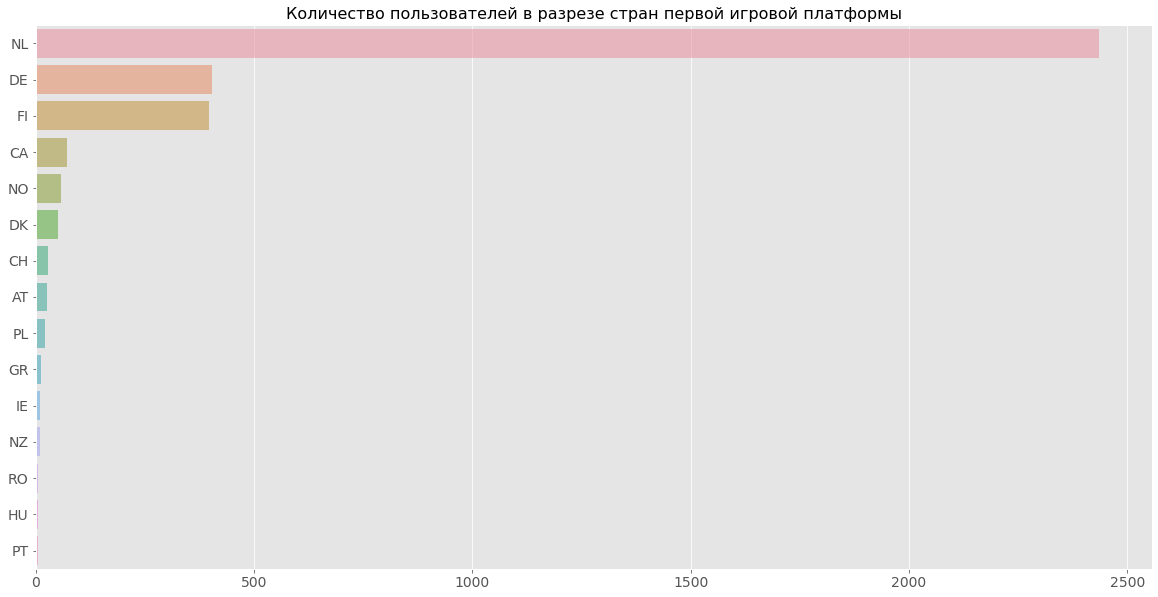

In [94]:
df1 = df.drop_duplicates(subset=['rra_playerId'])
countries = df1[df1['rra_brandId'] == '102']['rra_playerCountry'].value_counts()[df1['rra_playerCountry'] \
                                                                                 .value_counts(normalize=True)> 0.001]
plt.figure(figsize=(20,10))
plt.title("Количество пользователей в разрезе стран первой игровой платформы", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=countries.index, x=countries.values, alpha=0.6)
plt.show()

Большая часть пользователей данной платформы (1) преимущественно из Нидерланд, далее большие по численности 2 группы из Германии и Финляндии

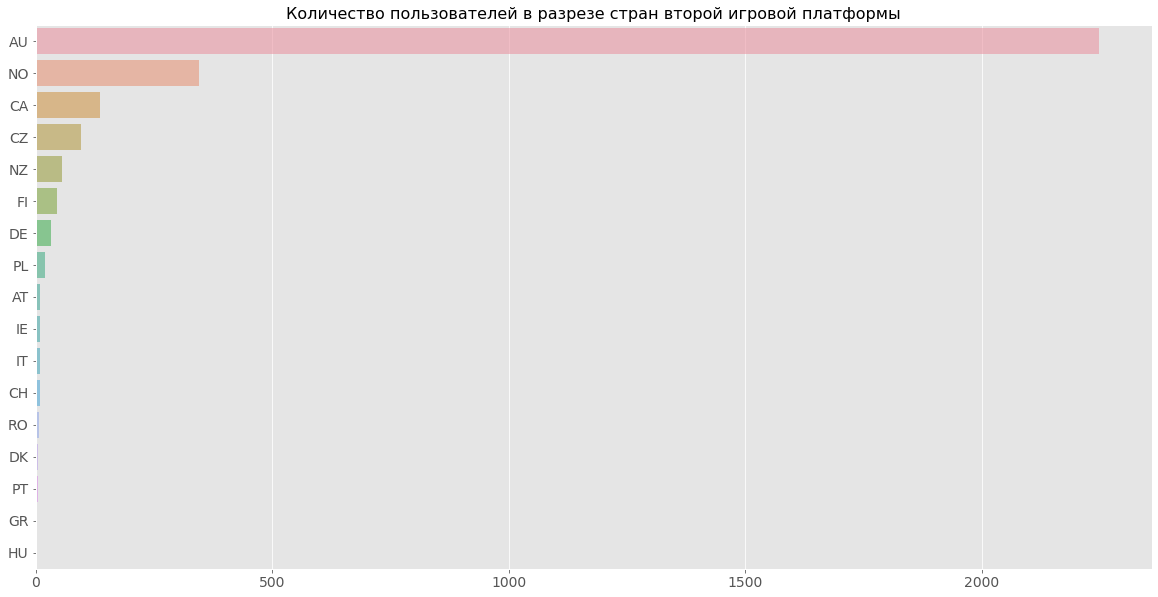

In [95]:
countries = df1[df1['rra_brandId'] == '99']['rra_playerCountry'].value_counts()[df1['rra_playerCountry'] \
                                                                            .value_counts(normalize=True)> 0.001]
plt.figure(figsize=(20,10))
plt.title("Количество пользователей в разрезе стран второй игровой платформы", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=countries.index, x=countries.values, alpha=0.6)
plt.show()

Платформа (2) наиболее популярна в Австралии

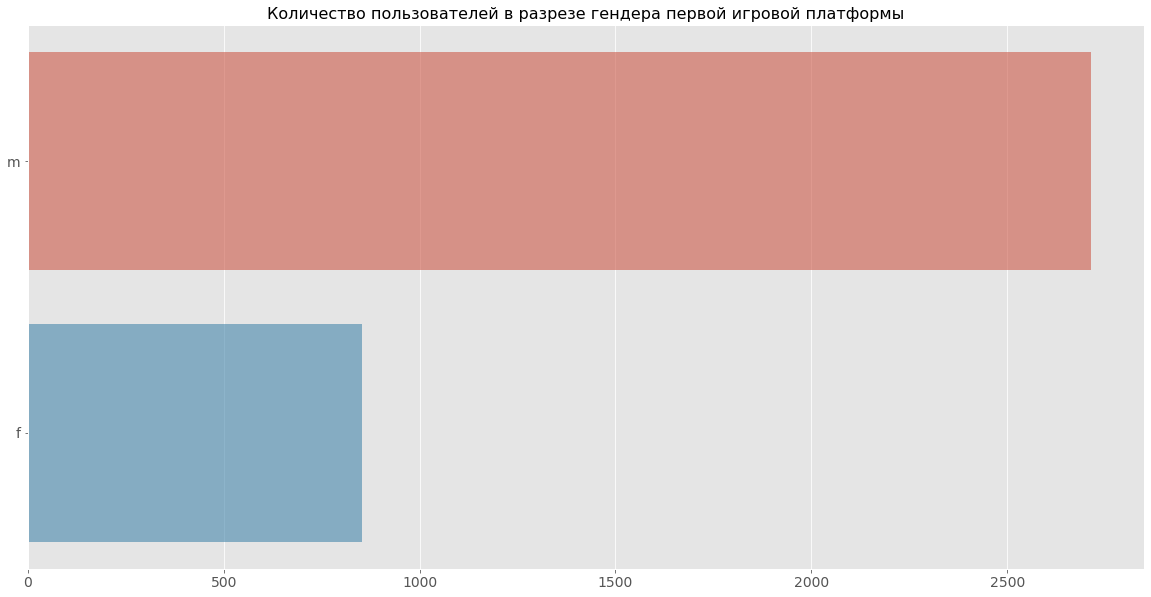

In [96]:
genders = df1[df1['rra_brandId'] == '102']['c_gender'].value_counts()[df1['c_gender'].value_counts(normalize=True)> 0.001]
plt.figure(figsize=(20,10))
plt.title("Количество пользователей в разрезе гендера первой игровой платформы", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=genders.index, x=genders.values, alpha=0.6)
plt.show()

Первая игровая платформа - Преимущественно мужчины

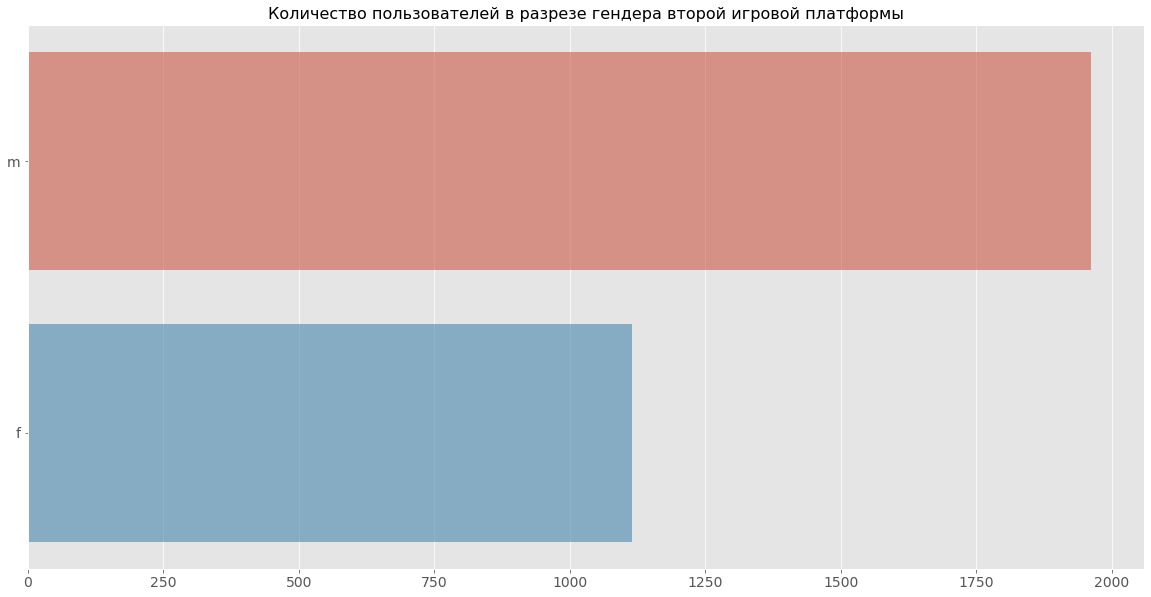

In [97]:
genders = df1[df1['rra_brandId'] == '99']['c_gender'].value_counts()[df1['c_gender'].value_counts(normalize=True)> 0.001]
plt.figure(figsize=(20,10))
plt.title("Количество пользователей в разрезе гендера второй игровой платформы", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=genders.index, x=genders.values, alpha=0.6)
plt.show()

Вторая игровая платформа - нельзя сказать о полном доминировании мужчин, женщин больше 50% от числа мужчин

<function matplotlib.pyplot.show(close=None, block=None)>

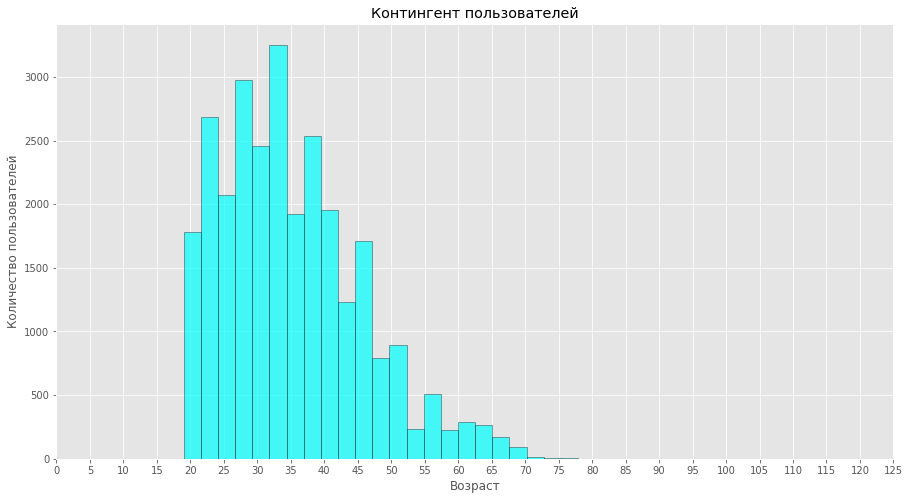

In [98]:
plt.figure(figsize=(15, 8))
plt.hist(df['c_age'], bins=25, facecolor='aqua', 
             alpha=0.7, edgecolor='black')
plt.grid(True)
plt.xticks(np.arange(0, 127, 5))
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Контингент пользователей')
plt.show


Основной контингет пользователей - 20 - 45 лет

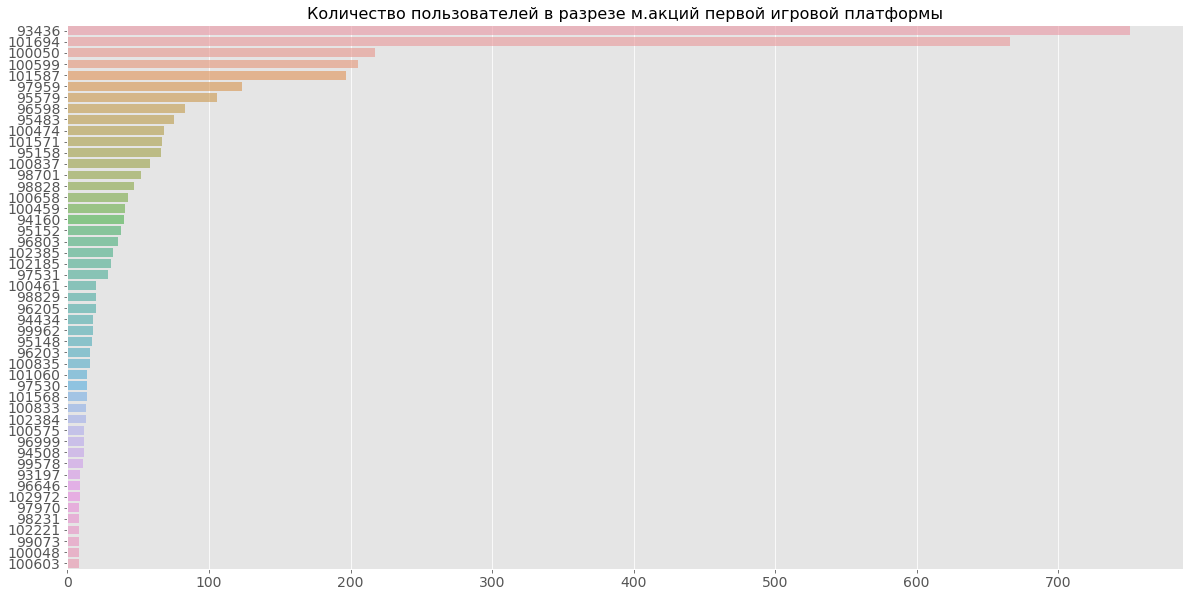

In [99]:
market = df1[df1['rra_brandId'] == '102']['rra_campaignId'].value_counts()[df1['rra_campaignId'] \
                                                                    .value_counts(normalize=True)> 0.001]
plt.figure(figsize=(20,10))
plt.title("Количество пользователей в разрезе м.акций первой игровой платформы", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=market.index, x=market.values, alpha=0.6)
plt.show()

Основную часть пользователей на первую игровую платформу привлекли 2 акции с указанными номерами

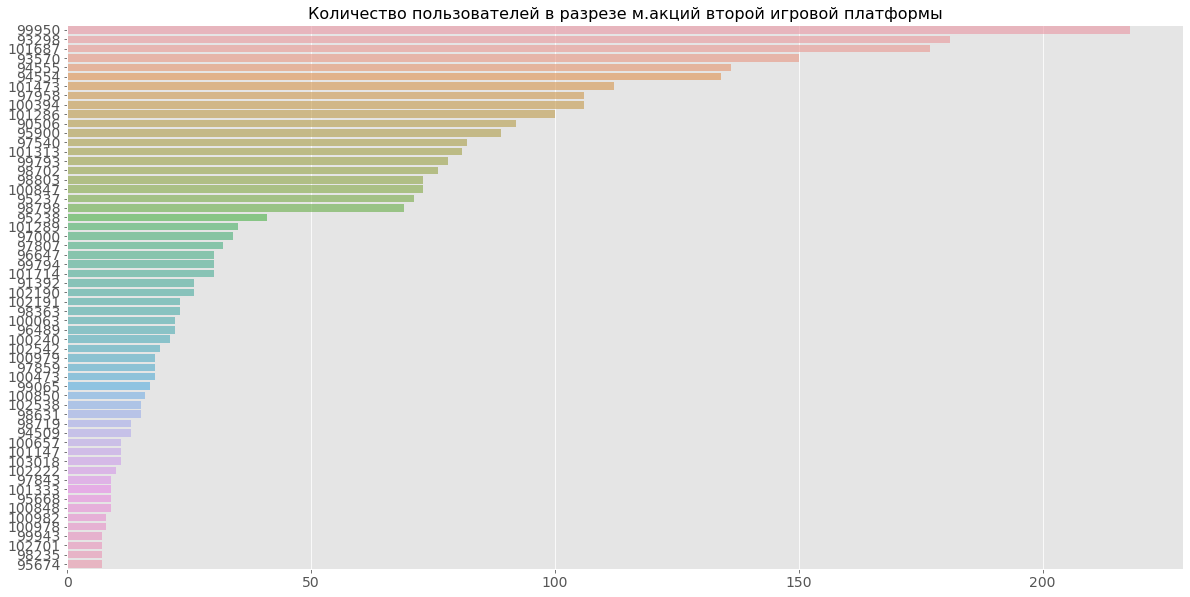

In [100]:
market = df1[df1['rra_brandId'] == '99']['rra_campaignId'].value_counts()[df1['rra_campaignId'] \
                                                                    .value_counts(normalize=True)> 0.001]
plt.figure(figsize=(20,10))
plt.title("Количество пользователей в разрезе м.акций второй игровой платформы", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=market.index, x=market.values, alpha=0.6)
plt.show()

Порядка 20 акций привлекли большую часть пользователей, нельзя сказать о полном превосходстве одной акции над другими

**Подсчет количества действий пользователей**

In [101]:
df['rra_playerId'].value_counts()

5401974    127
5417715    105
5476666     93
5366780     90
5465126     86
          ... 
5459956      1
5416884      1
5446848      1
5608145      1
5532646      1
Name: rra_playerId, Length: 6642, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

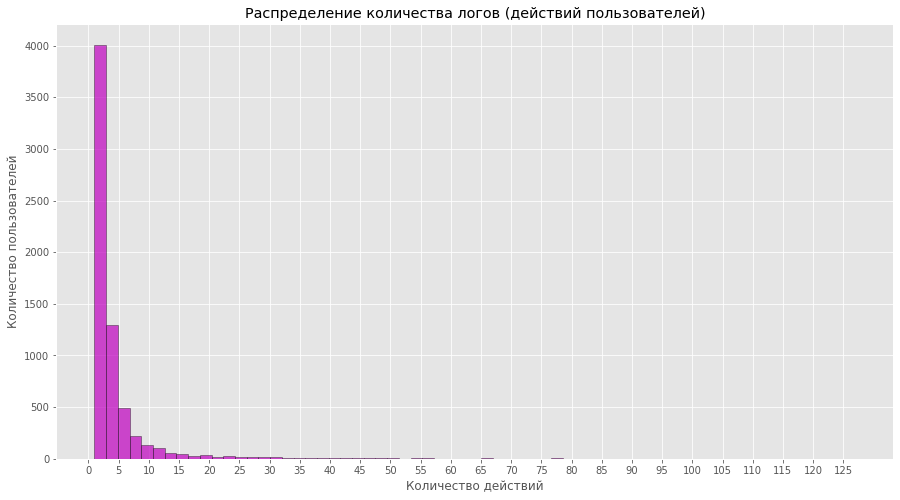

In [102]:
plt.figure(figsize=(15, 8))
plt.hist(df['rra_playerId'].value_counts(), bins=65, facecolor='m', 
             alpha=0.7, edgecolor='black')
plt.grid(True)
plt.xticks(np.arange(0, 127, 5))
plt.xlabel('Количество действий')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества логов (действий пользователей)')
plt.show

Основная часть пользователей (регистрация-сентябрь) совершила не более 1-4 действий, после чего происходит отток

**Максимальные количества суммированных депозитов**

In [103]:
df.groupby(['rra_playerId','rra_playerCountry', 'c_gender']).agg({'depositsSumEur' : 'sum'}) \
        .sort_values(by='depositsSumEur', ascending=False).head(20)

,,,depositsSumEur
rra_playerId,rra_playerCountry,c_gender,
5564627,NL,m,89470.00
5402759,NL,m,81850.00
5591992,NL,m,55229.00
5476666,AU,f,39667.69
5550147,NL,m,31625.00
5366780,NL,f,24864.00
5411214,AU,m,22830.05
5618510,NL,f,21445.00
5611058,AU,f,19322.57


Преимущественно аудитория из Нидерланд и Австралии

### 4. Рассчитать основные метрики (ARPU, удержание, LTV и т.п.)

**ARPU**

In [104]:
arpu_df = df.copy()
arpu_df['Time'] = arpu_df['rra_dateAt'].dt.time # Время логов
pd.DataFrame(arpu_df['Time']).value_counts()

Time    
03:00:00    28085
dtype: int64

In [105]:
arpu_df[(arpu_df['rra_depositsCount'] == 0) & (arpu_df['depositsSumEur'] != 0)] 

# Проверка условия, что у записей , где пользователи с нулевым количеством взносов - отсутсвует депозит

,rra_id,rra_playerId,rra_dateAt,rra_partnerId,rra_brandId,rra_campaignId,rra_playerCountry,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_registrationDateAt,c_gender,c_age,Cohort,Time


In [106]:
rev = arpu_df.groupby('rra_playerId')['depositsSumEur'].sum().sum() # Суммарный доход за все время

In [107]:
users = df.drop_duplicates(subset=['rra_playerId']).shape[0] # Количество уникальных пользователей за все время

In [108]:
arpu_total = rev  / users # ARPU за все время
print('ARPU:', arpu_total)

ARPU: 289.09221168322796


**ARPPU**

In [109]:
# У всех пользователей имеется запись первого депозита - первый вход в игру, отнести к платящим всех нет смысла
# Выбираются все записи, кроме первого депозита, где пользователи вносили средства на счет

print('Количество уникальных пользователей:', df.drop_duplicates(subset=['rra_playerId']).shape[0])
print('Количество записей о первом депозите :', df[df['firstDepositsSumEur'] > 0].shape[0])

Количество уникальных пользователей: 6642
Количество записей о первом депозите : 6642


In [110]:
# Выбираем для каждого пользователя первую запись (df1)
# Далее выбираем записи первых депозитов (df3)
# Соединяем оба массива и проверяем где совпадают обе даты

df1 = df.groupby('rra_playerId').agg({'rra_dateAt':'min'})
df2 = df[df['firstDepositsSumEur'] > 0][['rra_playerId', 'rra_dateAt']]
df3 = df1.merge(df2, on='rra_playerId')

print(df3.shape[0], df3[df3['rra_dateAt_x'] == df3['rra_dateAt_y']].shape[0])

6642 6642


Можно сделать вывод, что при первом заходе пользователю необходимо внести депозит для использования платформы

In [111]:
# Выбираются все записи, кроме первого депозита, где пользователи вносили средства на счет и рассматриваются как платящие

p_users = arpu_df[(arpu_df['firstDepositsSumEur'] == 0) & (arpu_df['depositsSumEur']!= 0)]
p_users = pd.DataFrame(p_users.groupby('rra_playerId')['depositsSumEur'].sum())
p_users_count = len(p_users) # Количество уникальных платящих пользователей за все время

In [112]:
arppu = rev / p_users_count # ARPPU за все время
print('ARPPU:', arppu)

ARPPU: 812.5901269572577


**DAU**

In [113]:
dau_df = df.copy()
dau_df['Date'] = dau_df['rra_dateAt'].dt.date # Доп. колонка даты без времени
dau = dau_df.groupby('Date').agg({'rra_playerId': 'nunique'}) # Подсчет уникальных пользоваталей за день
users_sum = dau.sum() # Всего уникальных пользователей за все дни
days = dau.shape[0] # Количество дней в выгрузке

dau = users_sum / days # Средний DAU за все дни
print('DAU:',round(dau[0], 3))


DAU: 242.896


**ARPDAU**

In [114]:
arpdau_df = df.copy()
arpdau_df['Date'] = arpdau_df['rra_dateAt'].dt.date

# Записи группируются по дате (дню), суммируется доход + считается количество уникальных пользователей за день
arpdau = arpdau_df.groupby('Date').agg({'depositsSumEur': 'sum', 'rra_playerId': 'nunique'})
arpdau['ARPDAU'] = arpdau['depositsSumEur'] / arpdau['rra_playerId'] # ARPDAU за каждый день
print('ARPDAU:', arpdau['ARPDAU'].mean().round(3)) # Средний ARPDAU рассматриваемого промежутка

ARPDAU: 82.855


In [115]:
arpdau

,depositsSumEur,rra_playerId,ARPDAU
Date,,,
2020-09-01,745.80,26,28.684615
2020-09-02,14574.67,296,49.238750
2020-09-03,18250.19,367,49.728038
2020-09-04,30970.86,401,77.234065
2020-09-05,19304.85,356,54.227107
...,...,...,...
2020-12-20,9689.25,79,122.648734
2020-12-21,8583.74,75,114.449867
2020-12-22,7157.59,83,86.236024


## Retention ##  

Все показатели Retention считаются для дня регистрации

In [116]:
# Пустой массив для результатов расчетов

ret_df = pd.DataFrame(index=['A', 'B', 'C', 'D'], 
                      columns=["1-day_retention", "7-days_retention", "14-days_retention", "30-days_retention"])
ret_df 

,1-day_retention,7-days_retention,14-days_retention,30-days_retention
A,NaN,NaN,NaN,NaN
B,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,NaN
D,NaN,NaN,NaN,NaN


**1-day Retention**

In [117]:
# Колонка с датой следующего после регистрации дня

df['reg + 1 day'] = df['c_registrationDateAt'].dt.date + datetime.timedelta(days=1)

one_day = []
for value in np.unique(df['Cohort']): # Цикл по когортам
    retention = df[df['Cohort'] == value][df['reg + 1 day'] == df['rra_dateAt'].dt.date] \
            .drop_duplicates(subset='rra_playerId').shape[0] / \
            df[df['Cohort'] == value].drop_duplicates(subset='rra_playerId').shape[0]
    print('Cohort - {}, 1-day Retention = {}%'.format(value, round(retention * 100, 2)))
    one_day.append(retention)

# Проверка логов, где дата записи совпадает с датой следующего после регистрации дня
# В цикле для каждой когорты вычисляется количество зашедших на следующий после регистрации день,
# и делится на общее количество уникальных пользователей в когорте

    
ret_df['1-day_retention'] = one_day  

Cohort - A, 1-day Retention = 26.08%
Cohort - B, 1-day Retention = 25.61%
Cohort - C, 1-day Retention = 27.44%
Cohort - D, 1-day Retention = 29.04%


In [118]:
total_ret = df[df['reg + 1 day'] == df['rra_dateAt'].dt.date] \
    .drop_duplicates(subset='rra_playerId').shape[0] / df.drop_duplicates(subset='rra_playerId').shape[0]
print('Total 1-day Retention = {}%'.format(round(total_ret * 100, 2)))

Total 1-day Retention = 26.93%


**7-day Retention**

In [119]:
df['reg + 7 days'] = df['c_registrationDateAt'].dt.date + datetime.timedelta(days=7)

seven_days = []
for value in df['Cohort'].unique():
    retention = df[df['Cohort'] == value][df['reg + 7 days'] == df['rra_dateAt'].dt.date] \
                .drop_duplicates(subset='rra_playerId').shape[0] / df[df['Cohort'] == value] \
                .drop_duplicates(subset='rra_playerId').shape[0]
    print('Cohort - {}, 7-day Retention = {}%'.format(value, round(retention * 100, 2)))
    seven_days.append(retention)
    
ret_df['7-days_retention'] = seven_days 

Cohort - C, 7-day Retention = 9.5%
Cohort - D, 7-day Retention = 8.96%
Cohort - B, 7-day Retention = 9.16%
Cohort - A, 7-day Retention = 7.17%


In [120]:
total_ret = df[df['reg + 7 days'] == df['rra_dateAt'].dt.date] \
                .drop_duplicates(subset='rra_playerId').shape[0] \
                    / df.drop_duplicates(subset='rra_playerId').shape[0]
print('Total 7-day Retention = {}%'.format(round(total_ret * 100, 2)))

Total 7-day Retention = 8.58%


In [121]:
total_ret = df[df['reg + 7 days'] == df['rra_dateAt'].dt.date] \
                .drop_duplicates(subset='rra_playerId').shape[0] \
                    / df.drop_duplicates(subset='rra_playerId').shape[0]
print('Total 7-day Retention = {}%'.format(round(total_ret * 100, 2)))

Total 7-day Retention = 8.58%


**14-day Retention**

In [122]:
df['reg + 14 days'] = df['c_registrationDateAt'].dt.date + datetime.timedelta(days=14)

fourteen_days = []
for value in df['Cohort'].unique():
    retention = df[df['Cohort'] == value][df['reg + 14 days'] == df['rra_dateAt'].dt.date] \
    .drop_duplicates(subset='rra_playerId').shape[0] / df[df['Cohort'] == value] \
        .drop_duplicates(subset='rra_playerId').shape[0]
    print('Cohort - {}, 14-day Retention = {}%'.format(value, round(retention * 100, 2)))
    fourteen_days.append(retention)

ret_df['14-days_retention'] = fourteen_days

Cohort - C, 14-day Retention = 7.79%
Cohort - D, 14-day Retention = 6.31%
Cohort - B, 14-day Retention = 7.17%
Cohort - A, 14-day Retention = 7.37%


In [123]:
total_ret14 = df[df['reg + 14 days'] == df['rra_dateAt'].dt.date] \
                .drop_duplicates(subset='rra_playerId').shape[0] \
                    / df.drop_duplicates(subset='rra_playerId').shape[0]
print('Total 14-day Retention = {}%'.format(round(total_ret14 * 100, 2)))

Total 14-day Retention = 7.18%


**30-day Retention**

In [124]:
df['reg + 30 days'] = df['c_registrationDateAt'].dt.date + datetime.timedelta(days=30)

thirty_days = []
for value in df['Cohort'].unique():
    retention = df[df['Cohort'] == value][df['reg + 30 days'] == df['rra_dateAt'].dt.date] \
                        .drop_duplicates(subset='rra_playerId').shape[0] / df[df['Cohort'] == value] \
                            .drop_duplicates(subset='rra_playerId').shape[0]
    print('Cohort - {}, 30-day Retention = {}%'.format(value, round(retention * 100, 2)))
    thirty_days.append(retention)
    
ret_df['30-days_retention'] = thirty_days

Cohort - C, 30-day Retention = 3.27%
Cohort - D, 30-day Retention = 2.65%
Cohort - B, 30-day Retention = 2.8%
Cohort - A, 30-day Retention = 2.6%


In [125]:
total_ret = df[df['reg + 30 days'] == df['rra_dateAt'].dt.date] \
            .drop_duplicates(subset='rra_playerId').shape[0] \
                / df.drop_duplicates(subset='rra_playerId').shape[0]
print('Total 30-day Retention = {}%'.format(round(total_ret * 100, 2)))

Total 30-day Retention = 2.82%


In [126]:
ret_df # Retention по когортам

,1-day_retention,7-days_retention,14-days_retention,30-days_retention
A,0.260806,0.094957,0.077931,0.032744
B,0.256075,0.089552,0.063094,0.026459
C,0.274394,0.091589,0.071651,0.028037
D,0.290366,0.071709,0.073674,0.026031


<function matplotlib.pyplot.show(close=None, block=None)>

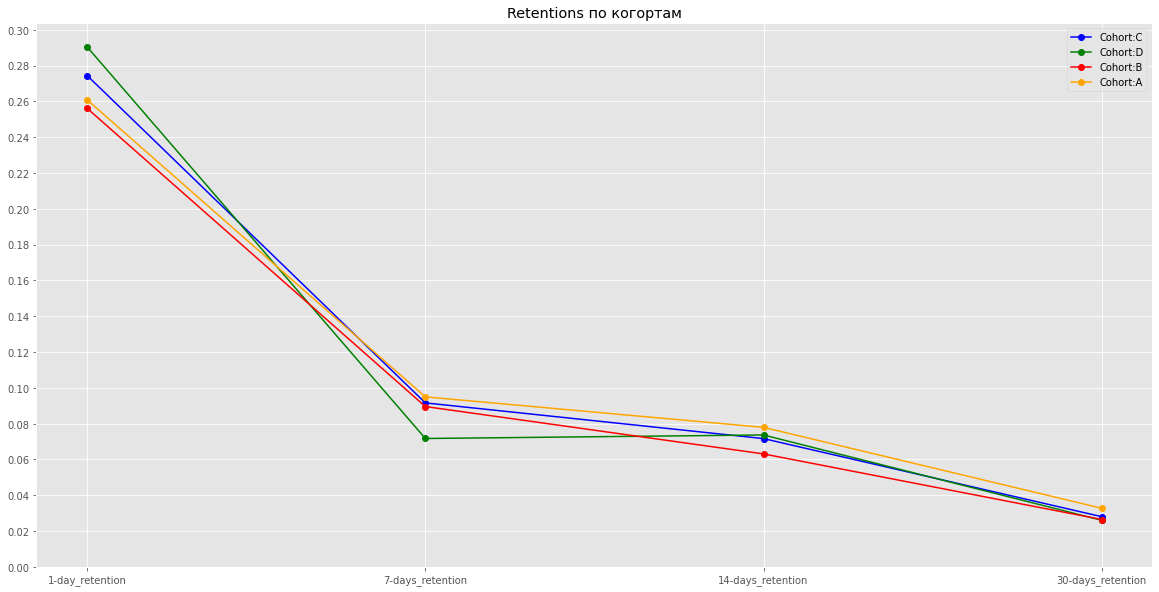

In [127]:
plt.figure(figsize=(20, 10))
colors = ['blue', 'green', 'red', 'orange']
plt.style.use('ggplot')

for i, value in enumerate(df['Cohort'].unique()):
    plt.plot(ret_df.loc[value, :], 'go-', label='Cohort:{}'.format(value), color=colors[i])
plt.yticks(np.arange(0, 0.31, 0.02))  
plt.legend()
plt.title('Retentions по когортам')
plt.show

**Общий Retention для 1-30 дня**

In [128]:
df3 = df.copy()
retentions_index = []
retentions_val = []

for i in range(1, 31):
    df3['reg + {} days'.format(i)] = df3['c_registrationDateAt'].dt.date + datetime.timedelta(days=i)
 
    retention = df3[df3['reg + {} days'.format(i)] == df3['rra_dateAt'].dt.date] \
            .drop_duplicates(subset='rra_playerId').shape[0] / df3.drop_duplicates(subset='rra_playerId').shape[0]
    print('Retention {} = {}%'.format(i, round(retention * 100, 2)))
    retentions_index.append('R{}'.format(i))
    retentions_val.append(retention)
    


Retention 1 = 26.93%
Retention 2 = 16.59%
Retention 3 = 12.48%
Retention 4 = 10.87%
Retention 5 = 8.99%
Retention 6 = 7.95%
Retention 7 = 8.58%
Retention 8 = 14.05%
Retention 9 = 7.21%
Retention 10 = 6.82%
Retention 11 = 5.95%
Retention 12 = 5.57%
Retention 13 = 5.01%
Retention 14 = 7.18%
Retention 15 = 18.96%
Retention 16 = 5.25%
Retention 17 = 4.52%
Retention 18 = 4.64%
Retention 19 = 4.2%
Retention 20 = 4.14%
Retention 21 = 4.16%
Retention 22 = 4.05%
Retention 23 = 3.55%
Retention 24 = 3.43%
Retention 25 = 3.27%
Retention 26 = 3.45%
Retention 27 = 3.19%
Retention 28 = 3.37%
Retention 29 = 3.0%
Retention 30 = 2.82%


<function matplotlib.pyplot.show(close=None, block=None)>

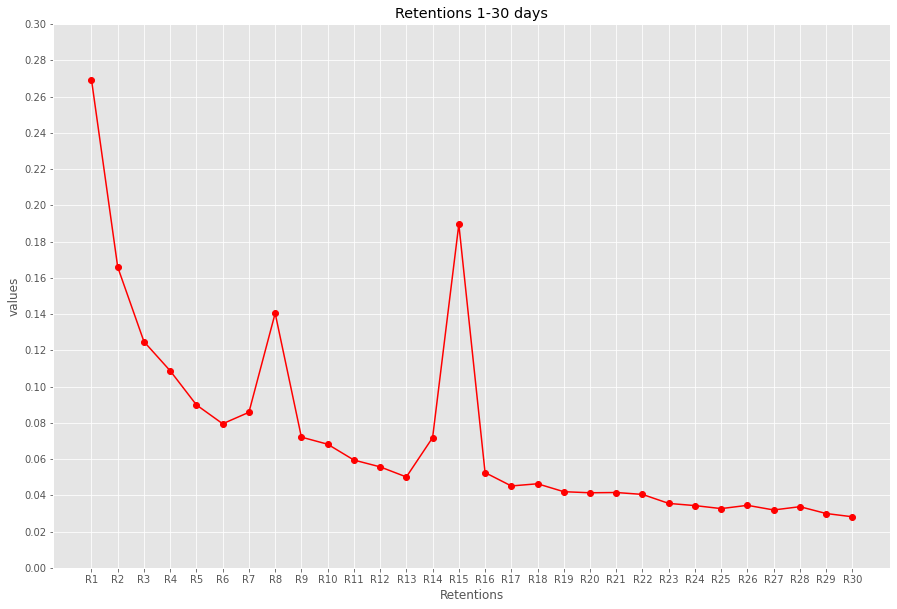

In [129]:
plt.figure(figsize=(15, 10))

plt.style.use('ggplot')
plt.plot(retentions_index, retentions_val,'go-', color='red')
plt.xlabel('Retentions')
plt.ylabel('values')
plt.yticks(np.arange(0, 0.31, 0.02)) 
plt.title('Retentions 1-30 days')
plt.show

На 8-ой и 15-ый день - резкое увеличение Retention - возможно в этот день были акции или рассылка push-уведомлений, в остальном график более чем похож на стандартный график Retention

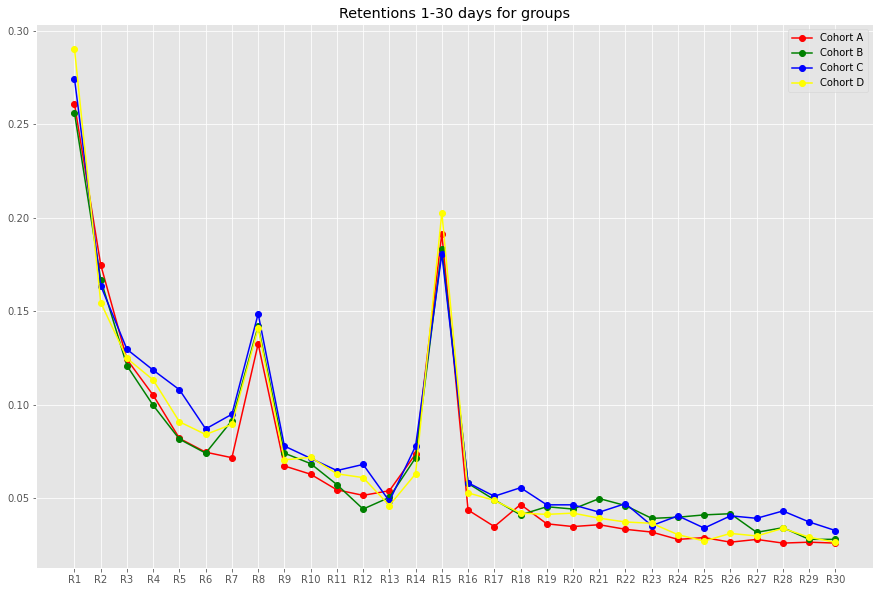

In [130]:
plt.figure(figsize=(15, 10))
plt.style.use('ggplot')
colors = ['red', 'green','blue','yellow']
for k, value in enumerate(['A', 'B', 'C', 'D']):
    df4 = df__a.copy()
    df4 = df4[df4['Cohort'] == value]
    retentions_index = []
    retentions_val = []

    for i in range(1, 31):
        df4['reg + {} days'.format(i)] = df4['c_registrationDateAt'].dt.date + datetime.timedelta(days=i)
        retention = df4[df4['reg + {} days'.format(i)] == df4['rra_dateAt'].dt.date].drop_duplicates(subset='rra_playerId').shape[0] / df4.drop_duplicates(subset='rra_playerId').shape[0]
        retentions_index.append('R{}'.format(i))
        retentions_val.append(retention)
    plt.plot(retentions_index, retentions_val,'go-', color=colors[k],label='Cohort {}'.format(value))
plt.title('Retentions 1-30 days for groups')
plt.legend()
plt.show()


**Наибольшие значения возвращений по дням общего числа пользователей**

In [131]:
# Через 7 дней

In [132]:
pd.DataFrame(df3[df3['reg + 7 days'] == df['rra_dateAt'].dt.date].iloc[:,0:-31].rra_dateAt.dt.date.value_counts()).sort_values(by='rra_dateAt', ascending=False).head(5)

,rra_dateAt
2020-09-10,37
2020-09-22,28
2020-10-01,28
2020-09-25,25
2020-09-29,25


In [133]:
df3[df3['reg + 7 days'] == df['rra_dateAt'].dt.date].describe()

,rra_id,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_age
count,5.700000e+02,570.0,570.000000,570.00000,570.000000,570.000000
mean,3.564291e+17,0.0,1.152632,2.91414,46.645421,35.012281
std,2.298376e+17,0.0,2.323458,10.58367,129.190649,10.437774
min,1.007787e+17,0.0,0.000000,0.00000,0.000000,19.000000
25%,1.983379e+17,0.0,0.000000,0.00000,0.000000,28.000000
50%,2.896490e+17,0.0,1.000000,0.00000,15.405000,33.000000
75%,3.244098e+17,0.0,1.000000,0.00000,39.330000,40.000000
max,9.522084e+17,0.0,30.000000,100.00000,1500.000000,68.000000


In [141]:
df3[df3['reg + 7 days'] == df['rra_dateAt'].dt.date]['depositsSumEur'].sum()

26587.89

In [144]:
df3[df3['reg + 7 days'] == df['rra_dateAt'].dt.date]['firstDepositsSumEur'].sum()

1661.06

In [134]:
# Через 8 дней

In [135]:
pd.DataFrame(df3[df3['reg + 8 days'] == df['rra_dateAt'].dt.date].iloc[:,0:-31].rra_dateAt.dt.date.value_counts()).sort_values(by='rra_dateAt', ascending=False).head(5)

,rra_dateAt
2020-09-10,53
2020-10-03,44
2020-09-12,43
2020-09-17,40
2020-09-16,39


In [136]:
df3[df3['reg + 8 days'] == df['rra_dateAt'].dt.date].describe()

,rra_id,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_age
count,9.330000e+02,933.0,933.000000,933.000000,933.000000,933.000000
mean,3.698259e+17,0.0,0.554126,1.079571,26.310654,34.661308
std,2.419017e+17,0.0,1.476030,6.073572,132.942344,10.386055
min,1.040487e+17,0.0,0.000000,0.000000,0.000000,19.000000
25%,1.931684e+17,0.0,0.000000,0.000000,0.000000,26.000000
50%,2.988484e+17,0.0,0.000000,0.000000,0.000000,33.000000
75%,4.685084e+17,0.0,1.000000,0.000000,15.340000,41.000000
max,9.792093e+17,0.0,20.000000,91.320000,3200.000000,73.000000


In [142]:
df3[df3['reg + 8 days'] == df['rra_dateAt'].dt.date]['depositsSumEur'].sum()

24547.839999999997

In [145]:
df3[df3['reg + 8 days'] == df['rra_dateAt'].dt.date]['firstDepositsSumEur'].sum()

1007.24

In [137]:
# Через 9 дней

In [138]:
pd.DataFrame(df3[df3['reg + 9 days'] == df['rra_dateAt'].dt.date].iloc[:,0:-31].rra_dateAt.dt.date.value_counts()).sort_values(by='rra_dateAt', ascending=False).head(5)

,rra_dateAt
2020-09-12,24
2020-09-11,24
2020-09-16,23
2020-09-20,21
2020-09-19,21


In [139]:
df3[df3['reg + 9 days'] == df['rra_dateAt'].dt.date].describe()

,rra_id,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_age
count,4.790000e+02,479.0,479.000000,479.000000,479.000000,479.000000
mean,3.619823e+17,0.0,0.939457,1.191461,54.245846,34.864301
std,2.383500e+17,0.0,1.516468,5.353188,235.067588,9.931795
min,1.005081e+17,0.0,0.000000,0.000000,0.000000,19.000000
25%,1.870341e+17,0.0,0.000000,0.000000,0.000000,27.000000
50%,2.839991e+17,0.0,0.000000,0.000000,0.000000,33.000000
75%,4.312099e+17,0.0,1.000000,0.000000,30.740000,42.000000
max,9.792093e+17,0.0,10.000000,50.000000,4300.000000,68.000000


In [143]:
df3[df3['reg + 9 days'] == df['rra_dateAt'].dt.date]['depositsSumEur'].sum()

25983.760000000002

In [146]:
df3[df3['reg + 9 days'] == df['rra_dateAt'].dt.date]['firstDepositsSumEur'].sum()

570.71

### LTV ###

**Подсчет LTV производится на основе показателей Retention (1-30 день) и среднего ARPDAU за рассматриваемый промежуток.**  
**LTV рассматривается как интеграл от Retention по времени, который прогнозируется на основе имеющихся значений**

**Средний lifetime (разность в днях между первым и последним заходом)**  
Расчитывается как суммированный lifetime всех пользователей / количество пользователей

In [140]:
df_copy = df.copy()
df_copy = df_copy.groupby('rra_playerId').agg({'rra_dateAt': ['min','max']}).reset_index()
df_copy['diff'] = df_copy['rra_dateAt', 'max'] - df_copy['rra_dateAt', 'min']
print('Average lifetime:', round(df_copy['diff'].sum().days / df_copy.shape[0], 3))

Average lifetime: 15.491
